In [189]:
from urllib import request
import nltk
import random
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string
from textblob import TextBlob
import wordcloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim
from sklearn.model_selection import train_test_split, cross_validate, learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_fscore_support, ConfusionMatrixDisplay, confusion_matrix, classification_report,f1_score
from mlxtend.evaluate import bias_variance_decomp
from sklearn.cluster import KMeans
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import seaborn as sns
from collections import defaultdict
%matplotlib inline
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [190]:
def get_raw(url):
  response = request.urlopen(url) # open a connection to the specified url and get the server's response to the HTTP request
  raw = response.read().decode('utf-8-sig') # read the content of the HTTP response as a sequence of bytes and then decode these bytes into a Unicode string using the UTF-8 encoding. The result is the text content of the specified url.
  return raw

In [191]:
def get_raw_from_author_to_closing(title,author,url):
  raw= get_raw(url)
  opening_statement= '.*start.*ebook.*\n' # lowercase since we will do the search with the lowercase version of the raw text to guarantee a match object
  closing_statement= '.*end.*ebook.*\n'  # lowercase since we will do the search with the lowercase version of the raw text to guarantee a match object

  start_position= re.search(opening_statement,raw.lower()).end() # start position is the end position of the opening statement
  if re.search(title.lower(),raw[start_position:].lower()): # if opening statement is followed by title
    start_position += re.search(title.lower(),raw[start_position:].lower()).end() # update start position to be end of title
    if re.search((author).lower(),raw[start_position:].lower()): # if title is followed by author name
      start_position += re.search((author).lower(),raw[start_position:].lower()).end() #update start position to be end of author name

  end_position= re.search(closing_statement,raw.lower()).start() # end position is the start position of the closing statement
  return raw[start_position:end_position]

In [192]:
def get_tokens(raw):
  words= nltk.word_tokenize(raw)
  return words

In [193]:
def extract_partitions(title,author,url,num_partitions,num_words_per_partition):
  raw= get_raw_from_author_to_closing(title,author,url) # get raw text from url
  words= get_tokens(raw) # get list of words/tokens from raw text
  partitions= []
  for i in range(num_partitions):
    start_index = random.randint(0, len(words) - num_words_per_partition) # generates a random starting index within the range of valid indices for the words list i.e. in such a way that the selected partition will not go beyond the end of the list
    partition = ' '.join(words[start_index:start_index + num_words_per_partition]) # Extracts a consecutive sequence of num_words_per_partition words starting from a the random position start_index and extending up to start_index + num_words_per_partition and joins the selected words into a single string by using space ' ' as a separator to form a sentence-like structure
    partitions.append(partition) # saves the partition in the list of partitions
  return partitions

In [194]:
def extract_from_multiple_books(books_details,num_partitions,num_words_per_partition):
  dict={'Partition':[],'Label':[], 'Book Title':[], 'Book Author':[]} # will be used to save each partition with its label and the title and author it belongs to
  for i in range(len(books_details)):
    partitions= extract_partitions(books_details[i]['title'],books_details[i]['author'],books_details[i]['url'],num_partitions,num_words_per_partition)
    for partition in partitions:
      dict['Partition'].append(partition)
      dict['Label'].append(books_details[i]['label'])
      dict['Book Title'].append(books_details[i]['title'])
      dict['Book Author'].append(books_details[i]['author'])
  return dict

In [195]:
def extract_and_save(books_details,num_partitions,num_words_per_partition):
  dict= extract_from_multiple_books(books_details,num_partitions,num_words_per_partition)

  # Assign series for partitions, labels, titles, and authors
  partitions= pd.Series(dict['Partition'])
  labels= pd.Series(dict['Label'])
  titles= pd.Series(dict['Book Title'])
  authors= pd.Series(dict['Book Author'])

  # Construct a data frame from the above series
  data= pd.DataFrame({'Book Title':titles, 'Book Author':authors, 'Label':labels, 'Partition':partitions })

  # Save the data to a csv file
  data.to_csv('sample_partitions.csv', index=False, encoding= 'utf-8-sig')
  return data

In [196]:
# Book 1 Details https://www.gutenberg.org/cache/epub/3695/pg3695.txt
url1 = 'https://www.gutenberg.org/cache/epub/4081/pg4081.txt'
title1= 'The Alchemist'
author1= 'Ben Jonson'
label1= 'a'
dict1= {'title':title1, 'author':author1, 'url':url1, 'label':label1}

# Book 2 Details
url2= 'https://www.gutenberg.org/cache/epub/1656/pg1656.txt'
title2= 'Apology'
author2= 'Plato'
label2= 'b'
dict2= {'title':title2, 'author':author2, 'url':url2, 'label':label2}

# Book 3 Details
url3= 'https://www.gutenberg.org/cache/epub/996/pg996.txt'
title3= 'Don Quixote'
author3= 'Miguel de Cervantes Saavedra'
label3= 'c'
dict3= {'title':title3, 'author':author3, 'url':url3, 'label':label3}

# Book 4 Details
url4= 'https://www.gutenberg.org/cache/epub/766/pg766.txt'
title4= 'David Copperfield'
author4= 'Charles Dickens'
label4= 'd'
dict4= {'title':title4, 'author':author4, 'url':url4, 'label':label4}

# Book 5 Details
url5= 'https://www.gutenberg.org/cache/epub/1727/pg1727.txt'
title5= 'The Odyssey'
author5= 'Homer'
label5= 'e'
dict5= {'title':title5, 'author':author5, 'url':url5, 'label':label5}

# Book 6 Details
url6= 'https://www.gutenberg.org/cache/epub/2554/pg2554.txt'
title6= 'Crime and Punishment'
author6= 'Fyodor Dostoyevsky'
label6= 'f'
dict6= {'title':title6, 'author':author6, 'url':url6, 'label':label6}

# All Books Details
books_details= [dict1, dict2, dict3, dict4,dict5, dict6]
books_details

[{'title': 'The Alchemist',
  'author': 'Ben Jonson',
  'url': 'https://www.gutenberg.org/cache/epub/4081/pg4081.txt',
  'label': 'a'},
 {'title': 'Apology',
  'author': 'Plato',
  'url': 'https://www.gutenberg.org/cache/epub/1656/pg1656.txt',
  'label': 'b'},
 {'title': 'Don Quixote',
  'author': 'Miguel de Cervantes Saavedra',
  'url': 'https://www.gutenberg.org/cache/epub/996/pg996.txt',
  'label': 'c'},
 {'title': 'David Copperfield',
  'author': 'Charles Dickens',
  'url': 'https://www.gutenberg.org/cache/epub/766/pg766.txt',
  'label': 'd'},
 {'title': 'The Odyssey',
  'author': 'Homer',
  'url': 'https://www.gutenberg.org/cache/epub/1727/pg1727.txt',
  'label': 'e'},
 {'title': 'Crime and Punishment',
  'author': 'Fyodor Dostoyevsky',
  'url': 'https://www.gutenberg.org/cache/epub/2554/pg2554.txt',
  'label': 'f'}]

In [197]:
data= extract_and_save(books_details,num_partitions=200,num_words_per_partition=150)

In [198]:
data

,Book Title,Book Author,Label,Partition
0,The Alchemist,Ben Jonson,a,"meet him . FACE . If I can hear of him , sir ,..."
1,The Alchemist,Ben Jonson,a,"the child-actor , and many more ; and this eve..."
2,The Alchemist,Ben Jonson,a,"Chamberlain 's company , in which Shakespeare ..."
3,The Alchemist,Ben Jonson,a,", news , S elling of flies , flat bawdry with ..."
4,The Alchemist,Ben Jonson,a,"a mournful melody . DURINDANA , Orlando 's swo..."
...,...,...,...,...
1195,Crime and Punishment,Fyodor Dostoyevsky,f,he pushed ? There ’ s a peasant woman with a b...
1196,Crime and Punishment,Fyodor Dostoyevsky,f,breath . “ It can not be . There was not the s...
1197,Crime and Punishment,Fyodor Dostoyevsky,f,"wasn ’ t so for me , though it might be for a ..."
1198,Crime and Punishment,Fyodor Dostoyevsky,f,"abandon you both if you are disobedient , and ..."


In [199]:
def clean_text_stem(text):
  text= text.lower()
  text= ''.join([char for char in text if char not in (string.punctuation + "‘’“”") ]) # remove punctuation to prevent tokenize function from considering them as words
  tokens= get_tokens(text)
  text_nostop= [word for word in tokens if word not in nltk.corpus.stopwords.words('english')]
  text_stemmed=' '.join([nltk.PorterStemmer().stem(word) for word in text_nostop])
  return text_stemmed

def clean_text_lem(text):
  text= text.lower()
  text= ''.join([char for char in text if char not in (string.punctuation + "‘’“”") ]) # remove punctuation to prevent tokenize function from considering them as words
  tokens= get_tokens(text)
  text_nostop= [word for word in tokens if word not in nltk.corpus.stopwords.words('english')]
  text_lemmatized= ' '.join([nltk.WordNetLemmatizer().lemmatize(word) for word in text_nostop])
  return text_lemmatized

data['Partition_stemmed']= data['Partition'].apply(lambda x: clean_text_stem(x))
data['Partition_lemmatized']= data['Partition'].apply(lambda x: clean_text_lem(x))
data

,Book Title,Book Author,Label,Partition,Partition_stemmed,Partition_lemmatized
0,The Alchemist,Ben Jonson,a,"meet him . FACE . If I can hear of him , sir ,...",meet face hear sir bring word unto lodg troth ...,meet face hear sir bring word unto lodging tro...
1,The Alchemist,Ben Jonson,a,"the child-actor , and many more ; and this eve...",childactor mani even though rigid law mine thi...,childactor many even though rigid law mine thi...
2,The Alchemist,Ben Jonson,a,"Chamberlain 's company , in which Shakespeare ...",chamberlain compani shakespear promin sharehol...,chamberlain company shakespeare prominent shar...
3,The Alchemist,Ben Jonson,a,", news , S elling of flies , flat bawdry with ...",news ell fli flat bawdri stone ill fume gone p...,news elling fly flat bawdry stone ill fume gon...
4,The Alchemist,Ben Jonson,a,"a mournful melody . DURINDANA , Orlando 's swo...",mourn melodi durindana orlando sword dwindl sh...,mournful melody durindana orlando sword dwindl...
...,...,...,...,...,...,...
1195,Crime and Punishment,Fyodor Dostoyevsky,f,he pushed ? There ’ s a peasant woman with a b...,push peasant woman babi beg curiou think happi...,pushed peasant woman baby begging curious thin...
1196,Crime and Punishment,Fyodor Dostoyevsky,f,breath . “ It can not be . There was not the s...,breath slightest caus sort ground lie lie rob ...,breath slightest cause sort ground lie lie rob...
1197,Crime and Punishment,Fyodor Dostoyevsky,f,"wasn ’ t so for me , though it might be for a ...",though might man would go straight goal withou...,though might man would go straight goal withou...
1198,Crime and Punishment,Fyodor Dostoyevsky,f,"abandon you both if you are disobedient , and ...",abandon disobedi abandon summon petersburg wel...,abandon disobedient abandon summoning petersbu...


Training and Testing

In [200]:
X_train, X_test, y_train, y_test = train_test_split(data['Partition_lemmatized'], data['Book Author'], test_size=0.2, random_state=42)

In [201]:
X_train.to_csv('X_train.csv', index=False, header=True, encoding= 'utf-8-sig')
X_test.to_csv('X_test.csv', index=False, header=True, encoding= 'utf-8-sig')
y_train.to_csv('y_train.csv', index=False, header=True, encoding= 'utf-8-sig')
y_test.to_csv('y_test.csv', index=False, header=True, encoding= 'utf-8-sig')

In [202]:
X_train= pd.read_csv('X_train.csv', encoding= 'utf-8-sig')
X_test= pd.read_csv('X_test.csv', encoding= 'utf-8-sig')
y_train= pd.read_csv('y_train.csv', encoding= 'utf-8-sig')
y_test= pd.read_csv('y_test.csv', encoding= 'utf-8-sig')

Vectorization function (tf-idf and bow)

In [203]:
def vectorize_text(data, column, method='tfidf'):
    if method == 'tfidf':
        vectorizer = TfidfVectorizer()
    elif method == 'bow':
        vectorizer = CountVectorizer()
    else:
        raise ValueError("Invalid method. Choose 'tfidf' or 'bow'.")

    vectorizer.fit(data[column])
    X_vectorized = vectorizer.transform(data[column])
    return X_vectorized, vectorizer

K-means clustering

In [204]:
def perform_kmeans(X_train, X_test, n_clusters=6):
    kmeans = KMeans(n_clusters=6, random_state=42)
    kmeans.fit(X_train)
    train_cluster_labels = kmeans.predict(X_train)
    test_cluster_labels = kmeans.predict(X_test)
    return train_cluster_labels, test_cluster_labels

Print cluster

In [205]:
def print_cluster_data(X_test, test_cluster_labels, y_test):
    # Add cluster labels to the test data
    X_test_with_clusters = X_test.copy()
    X_test_with_clusters['Cluster'] = test_cluster_labels

    # Initialize a dictionary to store samples for each cluster
    cluster_samples = {}

    # Iterate over unique cluster labels
    for cluster_label in np.unique(test_cluster_labels):
        # Get indices of samples belonging to the current cluster
        indices = np.where(test_cluster_labels == cluster_label)[0]
        # Get the samples
        samples = X_test_with_clusters.iloc[indices]
        # Add the samples to the dictionary
        cluster_samples[cluster_label] = samples

    # Display the samples for each cluster
    for cluster_label, samples in cluster_samples.items():
        author = y_test.iloc[samples.index[0]]  # Get author name from y_test
        print(f"Cluster: {cluster_label}, Author: {author.values[0]}")  # Print cluster label and author name
        for i, sample in samples.iterrows():
            partition = sample['Partition_lemmatized']
            print(f"  {partition}\n")
        print()

Get Cluster Data (Dictionary form)

In [206]:
def get_cluster_data(X_test, test_cluster_labels, y_test):
    # Add cluster labels to the test data
    X_test_with_clusters = X_test.copy()
    X_test_with_clusters['Cluster'] = test_cluster_labels

    # Initialize a dictionary to store samples for each author
    author_samples = {}

    # Iterate over unique cluster labels
    for cluster_label in np.unique(test_cluster_labels):
        # Get indices of samples belonging to the current cluster
        indices = np.where(test_cluster_labels == cluster_label)[0]
        # Get the samples
        samples = X_test_with_clusters.iloc[indices]
        # Get the author for the current cluster
        author = y_test.iloc[samples.index[0]].values[0]
        # Add the samples to the dictionary
        if author in author_samples:
            author_samples[author].extend(samples['Partition_lemmatized'].tolist())
        else:
            author_samples[author] = samples['Partition_lemmatized'].tolist()

    return author_samples

Cluster Visualization/Distribution

In [207]:
def visualize_clusters(X_train, cluster_labels, y_train):
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train.toarray())  # Convert sparse matrix to dense array

    # Create a DataFrame for easier manipulation
    df = pd.DataFrame(X_train_pca, columns=['PC1', 'PC2'])
    df['Cluster'] = cluster_labels
    df['Author'] = y_train.values

    # Create a mapping of cluster labels to majority author names
    cluster_to_majority_author = {}
    for cluster_label in df['Cluster'].unique():
        cluster_data = df[df['Cluster'] == cluster_label]
        majority_author = cluster_data['Author'].mode()[0]
        cluster_to_majority_author[cluster_label] = majority_author

    # Map cluster labels to majority author names
    df['Majority_Author'] = df['Cluster'].map(cluster_to_majority_author)

    # Plotting
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='PC1', y='PC2', hue='Majority_Author', data=df, palette='tab10')
    plt.title('PCA Visualization of Clusters (Author Names)')
    plt.show()

Kappa score against authors

In [208]:
def calculate_kappa_score(y_test, test_cluster_labels):
    cluster_to_majority_author = {}
    for cluster_label in np.unique(test_cluster_labels):
        indices = np.where(test_cluster_labels == cluster_label)[0]
        author_labels = y_test.iloc[indices]
        majority_author_label = author_labels.value_counts().idxmax()
        cluster_to_majority_author[cluster_label] = majority_author_label

    test_cluster_author = [cluster_to_majority_author[label] for label in test_cluster_labels]

    kappa = cohen_kappa_score(y_test, test_cluster_author)
    return kappa

#Results of tf-idf - - k-means

In [209]:
X_train_tfidf, tfidf_vectorizer = vectorize_text(X_train, 'Partition_lemmatized', method='tfidf')
X_test_tfidf = tfidf_vectorizer.transform(X_test['Partition_lemmatized'])

Clustering

In [210]:
train_cluster_labels_tfidf, test_cluster_labels_tfidf = perform_kmeans(X_train_tfidf, X_test_tfidf)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster data (tf-idf - - k-means)

In [211]:
get_cluster_data(X_test, test_cluster_labels_tfidf, y_test)

{'Plato': ['high matter defect overshadowed wisdom therefore asked behalf oracle whether would like neither knowledge ignorance like made answer oracle better inquisition led many enemy worst dangerous kind given occasion also many calumny called wise hearer always imagine posse wisdom find wanting others truth men athens god wise answer intends show wisdom men worth little',
  'evil either death long sleep best sleep journey another world soul dead gathered together may hope seeing hero old—in judge immortal fear one suffering death opinion nothing evil happen good man either life death death permitted god better depart therefore forgives judge done harm although never meant good last request make them—that trouble son',
  'meletus doer evil pretend earnest jest eager bring men trial pretended zeal interest matter really never smallest interest truth endeavour prove come hither meletus let ask question think great deal improvement youth yes tell judge improver must know taken pain dis

Cluster Distribution (tf-idf - - k-means)

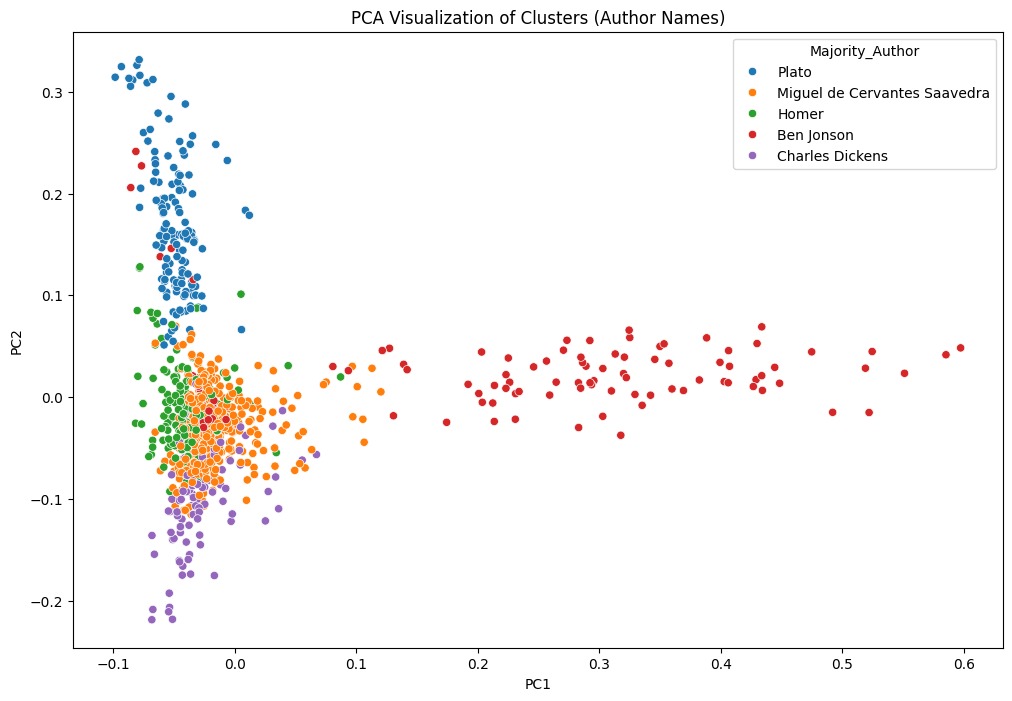

In [212]:
visualize_clusters(X_train_tfidf, train_cluster_labels_tfidf, y_train)

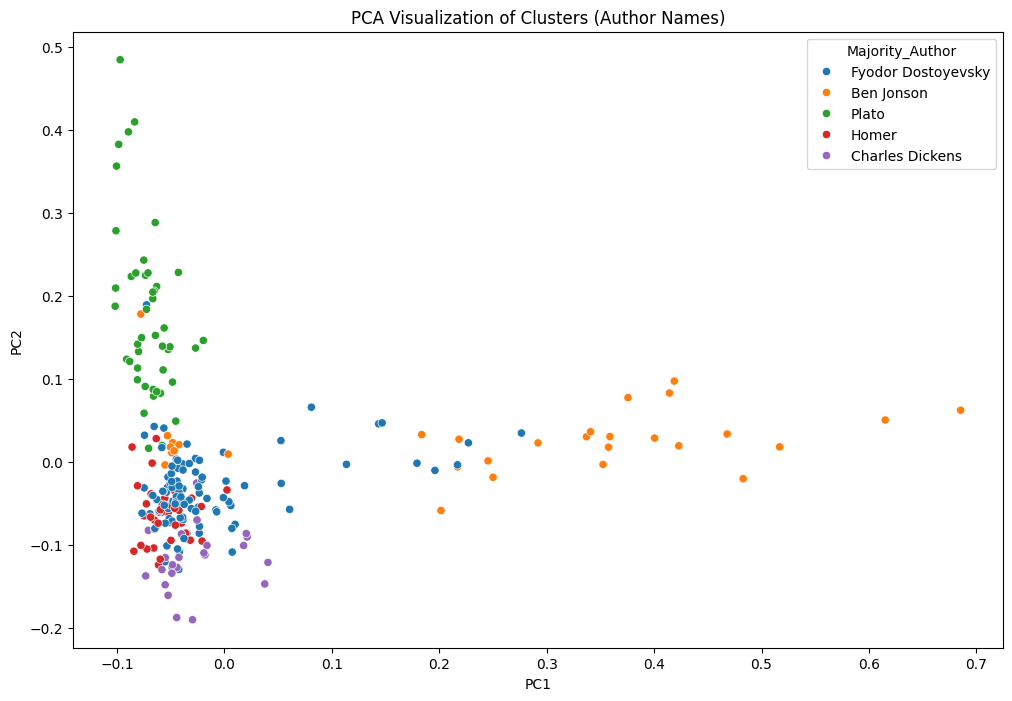

In [213]:
visualize_clusters(X_test_tfidf, test_cluster_labels_tfidf, y_test)

Kappa score against authors for tf-idf - - k-means

In [214]:
kappa_tfidf_test = calculate_kappa_score(y_test, test_cluster_labels_tfidf)
print(f"Cohen's Kappa (TF-IDF): {kappa_tfidf_test}")

Cohen's Kappa (TF-IDF): 0.6603255213753486


In [215]:
kappa_tfidf_train = calculate_kappa_score(y_train, train_cluster_labels_tfidf)
print(f"Cohen's Kappa (TF-IDF): {kappa_tfidf_train}")

Cohen's Kappa (TF-IDF): 0.6296706576291156


#Results of bow - - k-means

Vectorization using bow

In [216]:
X_train_bow, bow_vectorizer = vectorize_text(X_train, 'Partition_lemmatized', method='bow')
X_test_bow = bow_vectorizer.transform(X_test['Partition_lemmatized'])

Clustering

In [217]:
train_cluster_labels_bow, test_cluster_labels_bow = perform_kmeans(X_train_bow, X_test_bow)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster data (BOW -- k-means)

In [218]:
get_cluster_data(X_test, test_cluster_labels_bow, y_test)

{'Miguel de Cervantes Saavedra': ['let u return quixote left face bandaged doctored cat wound cured eight day one befell cide hamete promise relate exactitude truth wont set forth everything connected great history however minute may p47ejpg 12k chapter xlviii befell quixote doña rodriguez duchess duenna together occurrence worthy record eternal remembrance p48ajpg 131k full size exceedingly moody dejected sorely wounded quixote face bandaged marked hand god claw cat mishap incidental knighterrantry p48bjpg',
  'instrument duke astounded duchess amazed quixote wondering sancho panza trembling indeed even aware cause frightened fear silence fell upon postillion guise demon passed front blowing lieu bugle huge hollow horn gave horrible hoarse note ho brother courier cried duke going troop seem passing wood courier replied harsh discordant voice devil search quixote la mancha coming way',
  'day asked duke duchess grant permission take departure gave showing time sorry leaving p57bjpg 370

Cluster distribution/visualization (bow -- k-means)

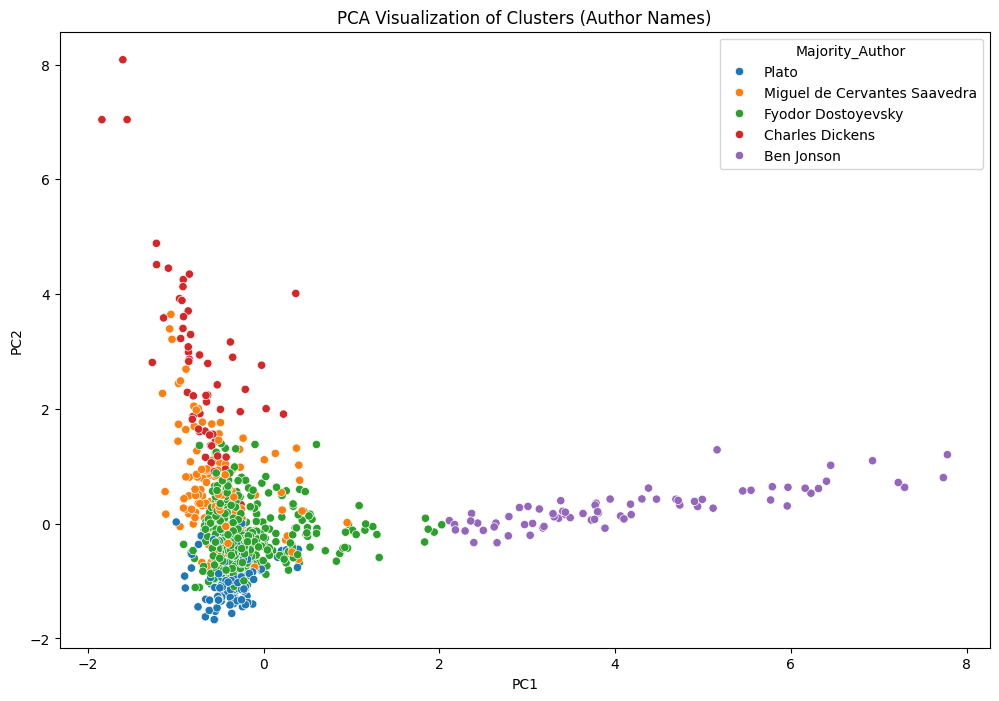

In [219]:
visualize_clusters(X_train_bow, train_cluster_labels_bow, y_train)

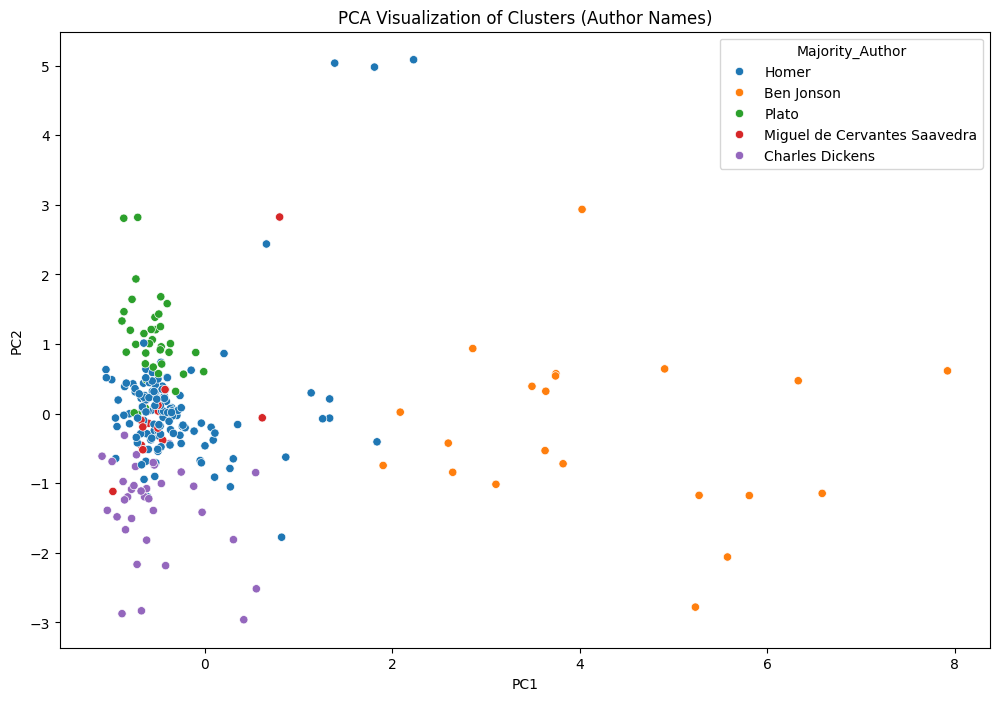

In [220]:
visualize_clusters(X_test_bow, test_cluster_labels_bow, y_test)

Kappa score against authors for bow - - k-means

In [221]:
kappa_bow_test = calculate_kappa_score(y_test, test_cluster_labels_bow)
print(f"Cohen's Kappa (BOW): {kappa_bow_test}")

Cohen's Kappa (BOW): 0.4458801101461555


In [222]:
kappa_bow_train = calculate_kappa_score(y_train, train_cluster_labels_bow)
print(f"Cohen's Kappa (BOW): {kappa_bow_train}")

Cohen's Kappa (BOW): 0.4268140045936406


Coherence

In [223]:
dict_1_train = get_cluster_data(X_train, train_cluster_labels_tfidf, y_train)
dict_2_train = get_cluster_data(X_train, train_cluster_labels_bow, y_train)

In [224]:
dict_1_test = get_cluster_data(X_test, test_cluster_labels_tfidf, y_test)
dict_2_test = get_cluster_data(X_test, test_cluster_labels_bow, y_test)

In [225]:
dict_1_train

{'Plato': ['never indicted meant let go certainly obey god rather man continue preach men age necessity virtue improvement refuse listen still persevere reprove way corrupting youth cease follow obedience god even thousand death await desirous let live—not sake heavensent friend never another may ludicrously described gadfly stir generous steed motion never taken part',
  'live go could good could greatest good privately every one thither went sought persuade every man among must look seek virtue wisdom look private interest look state look interest state order observes action shall done one doubtless good thing men athens reward good kind suitable would reward suitable poor man benefactor',
  'stoutly affirm unfortunate right suppose ask question horse one man harm world good exact opposite truth one man able good least many —the trainer horse say good others rather injure true meletus horse animal assuredly whether anytus say yes happy indeed would condition youth one corrupter rest 

In [226]:
dict_2_test

{'Miguel de Cervantes Saavedra': ['let u return quixote left face bandaged doctored cat wound cured eight day one befell cide hamete promise relate exactitude truth wont set forth everything connected great history however minute may p47ejpg 12k chapter xlviii befell quixote doña rodriguez duchess duenna together occurrence worthy record eternal remembrance p48ajpg 131k full size exceedingly moody dejected sorely wounded quixote face bandaged marked hand god claw cat mishap incidental knighterrantry p48bjpg',
  'instrument duke astounded duchess amazed quixote wondering sancho panza trembling indeed even aware cause frightened fear silence fell upon postillion guise demon passed front blowing lieu bugle huge hollow horn gave horrible hoarse note ho brother courier cried duke going troop seem passing wood courier replied harsh discordant voice devil search quixote la mancha coming way',
  'day asked duke duchess grant permission take departure gave showing time sorry leaving p57bjpg 370

Coherence

In [227]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def calculate_coherence(dict_1, dict_2):
    coherence_scores = {}

    for author in dict_1.keys():
        if author in dict_2:
            # Concatenate all samples for the author from both dictionaries
            all_samples = dict_1[author] + dict_2[author]

            # Initialize a TF-IDF vectorizer
            vectorizer = TfidfVectorizer()
            tfidf_matrix = vectorizer.fit_transform(all_samples)

            # Calculate cosine similarity between the samples
            similarity_matrix = cosine_similarity(tfidf_matrix)

            # Get the similarity score between the samples from dict_1 and dict_2
            similarity_score = similarity_matrix[:len(dict_1[author]), len(dict_1[author]):].mean()

            coherence_scores[author] = similarity_score

    return coherence_scores

In [228]:
coherence_scores_train = calculate_coherence(dict_1_train, dict_2_train)
for author, score in coherence_scores_train.items():
    print(f"Coherence score for {author}: {score}")

Coherence score for Plato: 0.05491851540583832
Coherence score for Miguel de Cervantes Saavedra: 0.02490566101498835
Coherence score for Ben Jonson: 0.02513355560341569
Coherence score for Charles Dickens: 0.04759711498611397


In [229]:
coherence_scores_test = calculate_coherence(dict_1_test, dict_2_test)
for author, score in coherence_scores_test.items():
    print(f"Coherence score for {author}: {score}")

Coherence score for Plato: 0.07271936077460343
Coherence score for Fyodor Dostoyevsky: 0.02667917104664994
Coherence score for Ben Jonson: 0.10132887881198337
Coherence score for Charles Dickens: 0.05907399962532882


Silhouette

In [230]:
from sklearn.metrics import silhouette_score

In [231]:
#X_test_tfidf
#test_cluster_labels_tfidf
silhouette_avg_train = silhouette_score(X_train_tfidf, train_cluster_labels_tfidf)
print("Silhouette Score:", silhouette_avg_train)

Silhouette Score: 0.01152143760811779


In [232]:
silhouette_avg_test = silhouette_score(X_test_bow, test_cluster_labels_bow)
print("Silhouette Score:", silhouette_avg_test)

Silhouette Score: 0.009199834739602309
